# Experiment: Train Sequential LSTM Model

## Confirm Environment

In [1]:
!conda info


     active environment : northeastern
    active env location : /home/curtis/anaconda3/envs/northeastern
            shell level : 2
       user config file : /home/curtis/.condarc
 populated config files : /home/curtis/anaconda3/.condarc
          conda version : 24.9.2
    conda-build version : 24.9.0
         python version : 3.12.7.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=skylake
                          __conda=24.9.2=0
                          __glibc=2.39=0
                          __linux=6.6.87.2=0
                          __unix=0=0
       base environment : /home/curtis/anaconda3  (writable)
      conda av data dir : /home/curtis/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://r

## Setup and Imports

In [2]:
from emolex.preprocessing import load_mental_health_sentiment_dataset, clean_text, encode_sentiment_labels, split_data, dl_text_vectorization
from emolex.dl_models import lstm_model 
from emolex.train import train_dl_model
from emolex.evaluation import plot_training_history, generate_confusion_matrix, generate_classification_report
from emolex.utils import detect_and_set_device

2025-07-02 15:44:40.105349: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 15:44:40.132332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751485480.152822   47718 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751485480.158476   47718 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751485480.175148   47718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Device Setup

In [3]:
# Detect and set up GPU or use CPU
device_used = detect_and_set_device()
print(f"TensorFlow is configured to use: {device_used}")

No GPU devices found despite TensorFlow being built with CUDA. Using CPU.
TensorFlow is configured to use: CPU


2025-07-02 15:44:48.045014: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Load Data

In [4]:
df = load_mental_health_sentiment_dataset()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51093 entries, 0 to 51092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    51093 non-null  object
 1   label   51093 non-null  object
dtypes: object(2)
memory usage: 798.5+ KB


,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


## Clean Data

In [5]:
print(f"\n--- Cleaning Text ---")
df['clean_text'] = df["text"].apply(clean_text)
print("Text cleaning complete. Sample cleaned text:")
print("\n", df[["text", "clean_text"]].sample(5))


--- Cleaning Text ---
Text cleaning complete. Sample cleaned text:

                                                     text  \
13661  I know its not super helpful to self diagnose,...   
6980   I am so damn exhausted of my mind screwing eve...   
37465  i ve had depression for a long a i can remembe...   
44075                             hr need to go by quick   
49712  I’m too scared for therapy. I have social anxi...   

                                              clean_text  
13661  know super helpful self diagnose seems like lo...  
6980   damn exhausted mind screwing everything turn w...  
37465  depression long remember really day sad absolu...  
44075                                   hr need go quick  
49712  im scared therapy social anxiety avoidant pers...  


## Encode Labels

In [6]:
print(f"\n--- Encoding Labels ---")
df, encoder = encode_sentiment_labels(df)
print("Label encoding complete. Sample encoded labels:")
print("\n", df[['label', 'label_encoded']].sample(5))


--- Encoding Labels ---
Label Encoding Map: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}
Label encoding complete. Sample encoded labels:

           label  label_encoded
20349  Suicidal              6
26191  Suicidal              6
33625   Anxiety              0
45307   Bipolar              1
42626    Normal              3


## Train-Test Split

In [7]:
print("\n--- Perform Train-Test Split ---")
X_train_raw, X_test_raw, y_train, y_test = split_data(df) 
print(f"Train set size: {len(X_train_raw)} samples")
print(f"Test set size: {len(X_test_raw)} samples")


--- Perform Train-Test Split ---
Train set size: 40874 samples
Test set size: 10219 samples


## Vectorization

In [8]:
print("\n--- Performing Text Vectoriation ---")
X_train_pad_filtered, X_test_pad_filtered, y_train_filtered, y_test_filtered = dl_text_vectorization(X_train_raw, X_test_raw, y_train, y_test)
print("Vecorization complete.")


--- Performing Text Vectoriation ---
Original X_train shape: (40874,), Filtered X_train_pad shape: (40807, 100)
Original X_test shape: (10219,), Filtered X_test_pad shape: (10205, 100)
Vecorization complete.


## Build Model

In [9]:
print("\n--- Build Model ---")
model = lstm_model(num_classes=len(encoder.classes_), vocab_size=10000, max_len=100)


--- Build Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,463,303 (5.58 MB)

 Trainable params: 1,463,303 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [10]:
print("\n--- Training Model ---")
model, history = train_dl_model(model, X_train_pad_filtered, y_train_filtered, X_test_pad_filtered, y_test_filtered, epochs=20)


--- Training Model ---
Starting model training for 2 epochs with batch size 32...
Epoch 1/2
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 347s 270ms/step - accuracy: 0.4611 - loss: 1.3312 - val_accuracy: 0.6100 - val_loss: 0.8809
Epoch 2/2
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 431s 289ms/step - accuracy: 0.6356 - loss: 0.8493 - val_accuracy: 0.6975 - val_loss: 0.7428
Restoring model weights from the end of the best epoch: 2.
Model training complete.


## Evaluate Model


--- Plot Training History ---


/mnt/c/grad_school/northeastern/ie7500/project/NLP_Project/src/emolex/evaluation.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Accuracy (or Loss)'}, xlabel='Epochs'>)

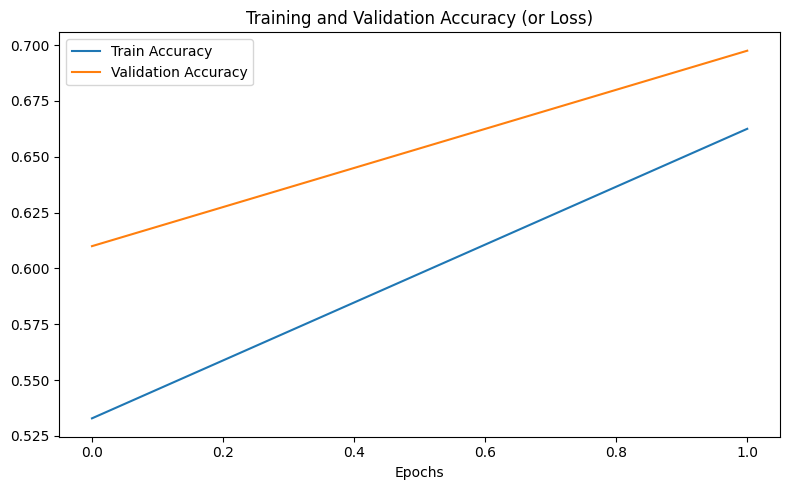

In [11]:
print("\n--- Plot Training History ---")
plot_training_history(history)

In [12]:
print("\n--- Predict Test Classes ---")
y_pred = model.predict(X_test_pad_filtered)
y_pred_classes = y_pred.argmax(axis=1)


--- Predict Test Classes ---
319/319 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step



--- Generate Confusion Matrix ---


/mnt/c/grad_school/northeastern/ie7500/project/NLP_Project/src/emolex/evaluation.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


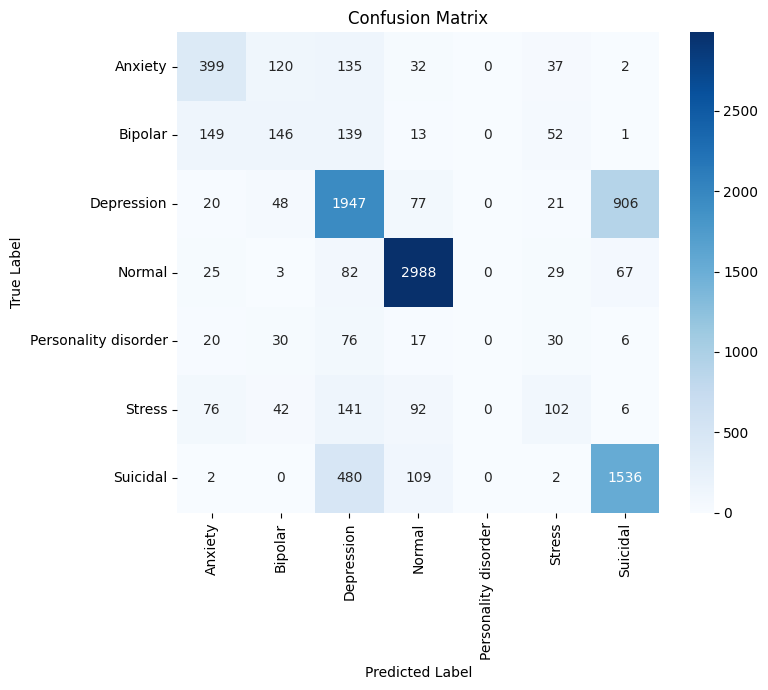

In [13]:
print("\n--- Generate Confusion Matrix ---")
fig, ax = generate_confusion_matrix(y_test_filtered, y_pred_classes, class_labels=encoder.classes_)

In [14]:
print("\n--- Generate Classification Report ---")
generate_classification_report(y_test_filtered, y_pred_classes, class_labels=encoder.classes_)


--- Generate Classification Report ---
                      precision    recall  f1-score   support

             Anxiety       0.58      0.55      0.56       725
             Bipolar       0.38      0.29      0.33       500
          Depression       0.65      0.64      0.65      3019
              Normal       0.90      0.94      0.92      3194
Personality disorder       0.00      0.00      0.00       179
              Stress       0.37      0.22      0.28       459
            Suicidal       0.61      0.72      0.66      2129

            accuracy                           0.70     10205
           macro avg       0.50      0.48      0.48     10205
        weighted avg       0.68      0.70      0.68     10205



/home/curtis/anaconda3/envs/northeastern/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/curtis/anaconda3/envs/northeastern/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/curtis/anaconda3/envs/northeastern/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod